In [1]:
%load_ext autoreload

In [2]:
%autoreload
import torch
import torch.nn as nn
import torchvision
import numpy as np
from gpt.model import ViT, Lambda, LightningWrapper, hMLP_stem, ClassificationHead
from gpt.data import MNISTDataModule, CIFAR10DataModule, Galaxy10DataModule, ImagenetH5DataModule
from tqdm.auto import tqdm
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from rich.progress import track
from einops.layers.torch import Rearrange
from einops import rearrange, repeat, einsum

[2024-01-29 13:45:56,647] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
# def collate(lop):
#     x, y = zip(*lop)
#     x = torch.stack(x)
#     return x.view(-1, *x.shape[1:]), torch.tensor(y).unsqueeze(-1).repeat(1, x.shape[1]).view(-1).long()

def collate(lop):
    x, y = zip(*lop)
    x = torch.stack(x)
    y = torch.tensor(y)
    print(x.shape)
    ncrops = x.shape[1]
    y = repeat(y, 'n -> n c', c=ncrops).ravel()
    x = rearrange(x, 'b n c h w -> (b n) c h w')
    return x, y

mnist = MNISTDataModule(root_dir='/scratch/gpfs/js5013/data/ml', num_workers=1, batch_size=8, pin_memory=False)#, collate_fn_train=collate, extra_transforms=[transforms.FiveCrop(28), Lambda(torch.stack)])#, collate_fn=collate)
mnist.setup()

In [4]:
tl = mnist.test_dataloader()

In [5]:
x, y = next(iter(tl))

In [6]:
x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [24]:
ckpt = '../train/lightning_logs/version_0/checkpoints/epoch=4-step=9375.ckpt'
model = LightningWrapper.load_from_checkpoint(ckpt, strict=False).cuda()
# model.model.output_head = ClassificationHead(model.model.embed_dim, 10)
# sd = torch.load(ckpt, map_location='cpu')
# model.model.load_state_dict({k.replace('model.', ''): v for k, v in sd['state_dict'].items()})
# model.freeze()

/scratch/gpfs/js5013/.conda/envs/foundation/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'output_head' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_head'])`.


In [25]:
def show(imgs, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(mnist.unnormalize(img))
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(None, tensor([9, 0, 1, 2, 3, 4, 5, 6]))

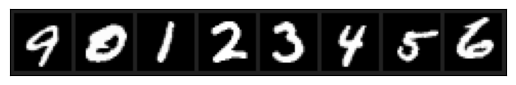

In [26]:
show(torchvision.utils.make_grid(x)), y# + torch.randn(x.shape) * torch.std(x, axis=(0, 2, 3), keepdim=True) * 0.0)), list(map(lambda i: mnist.classes[i], y))

In [27]:
torch.argmax(model(x.cuda()), axis=1)

tensor([9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')

In [28]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x.cuda()).cpu()
        pred = torch.argmax(out, 1)
    score += torch.sum(pred == y)
    total += x.shape[0]

Output()

In [29]:
score / total

tensor(0.9585)

In [18]:
def collate(lop):
    x, _ = zip(*lop)
    x = torch.stack(x)
    return x

cifar = CIFAR10DataModule(batch_size=4, num_workers=1, root_dir='/mnt/home/jshen/ceph/data/ml/')#, collate_fn=collate)
cifar.setup()

In [19]:
tl = cifar.test_dataloader()

In [20]:
x, y = next(iter(tl))

In [21]:
x.shape, y.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [22]:
score = 0
total = 0
for x, y in track(tl, total=len(tl)):
    with torch.no_grad():
        out = model(x)
        pred = torch.argmax(out, 1)
    score += torch.sum(pred == y)
    total += x.shape[0]

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:07:48

In [23]:
score / total

tensor(0.7640)

In [3]:
LightningWrapperimage_channels=3, num_blocks=1, embed_dim=384, patch_size=(16, 16))

In [4]:
v.nparams / 1e6

7.225088

In [5]:
x = torch.randn(4, 3, 64, 64)

In [6]:
v(x).shape

torch.Size([4, 16, 384])

In [7]:
x = torch.randn(4, 3, 32, 32)

In [8]:
v(x).shape

torch.Size([4, 4, 384])